**Information**

***Tire offsets***  
Generally the offset from soft to medium tires is +0.6  
Generally the offset from medium to hard tires is +0.7

***Tire wear***
Generally:
- C1: 30-50
- C2: 25-35
- C3: 20-30
- C4: 15-25
- C5: 10-15

***Downforce***  
- High downforce: More stress on the tires, more tire wear  
- Low downforce: Less stress on the tires, less tire wear

***Available tire sets during a race***
- 2 scrubbed soft
- 2 new medium
- 1 new hard
- 1 scrubbed hard

**Probability of decay**
- Softs (10 - 25): 1% for the first 10 laps, 2% for the next 10 laps, 4% for the next 5 laps, puncture region post this.
- Mediums (20 - 35): 0.5% for the first 10 laps, 1% for the next 10 laps, 2% for the next 10 laps, 3% for the next 5, puncture region post this.
- Hards (25-50): 0.2% for the first 10, 0.5% for the next 10, 1% for the next 10, 1.5% for the next 10, 2% for the next 10, puncture region post this. 

**Logic**  
***Outcome:*** Find the fastest time for the entire race

In [2]:
import fastf1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fastf1.plotting
import scipy.stats as sts

In [3]:
practice_1 = fastf1.get_session(2021, 'Monaco Grand Prix', 'FP1')
practice_2 = fastf1.get_session(2021, 'Monaco Grand Prix', 'FP2')
practice_3 = fastf1.get_session(2021, 'Monaco Grand Prix', 'FP3')

practice_1.load()
practice_2.load()
practice_3.load()

req         WARNING 	

DEFAULT CACHE ENABLED!
	Cache directory: C:\Users\abdul\AppData\Local\Temp\fastf1.
	Size: 384.88 MB


core           INFO 	Loading data for Monaco Grand Prix - Practice 1 [v3.1.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '14', '16', '18', '22', '3', '31', '33', '4', '44', '47', '5', '55', '6', '63', '7', '77', '9', '99']
core           INFO 	Loading data for Monaco Grand Prix - Practice 2 [v3.1.3]
req            INFO 	Using cached 

In [4]:
def data_pre_processing(df):
    convert_to_seconds = lambda x: x.total_seconds() if pd.Timedelta == type(x) else x
    df = df.applymap(convert_to_seconds)
    df.replace({np.nan: None}, inplace=True)
    # set a new column "Pit" to True if the PitOutTime is not null or PitInTime is not null
    df['Pit'] = df['PitOutTime'].notnull() | df['PitInTime'].notnull()
    return df

def practice_subset(df):
    return df[['Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
               'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
               'IsPersonalBest', 'Compound', 'TyreLife', 'Team', 'Deleted', 'Pit']]

In [5]:
hamilton_fp1 = practice_1.laps.pick_driver('HAM')
hamilton_fp2 = practice_2.laps.pick_driver('HAM')
hamilton_fp3 = practice_3.laps.pick_driver('HAM')

hamilton_fp1 = data_pre_processing(hamilton_fp1)
hamilton_fp2 = data_pre_processing(hamilton_fp2)
hamilton_fp3 = data_pre_processing(hamilton_fp3)

hamilton_fp1 = practice_subset(hamilton_fp1)
hamilton_fp2 = practice_subset(hamilton_fp2)
hamilton_fp3 = practice_subset(hamilton_fp3)

hamilton_fp1 = hamilton_fp1[hamilton_fp1['Pit'] == False]
hamilton_fp2 = hamilton_fp2[hamilton_fp2['Pit'] == False]
hamilton_fp3 = hamilton_fp3[hamilton_fp3['Pit'] == False]

# pick the quick laps
hamilton_fp1 = hamilton_fp1.pick_quicklaps()
hamilton_fp2 = hamilton_fp2.pick_quicklaps()
hamilton_fp3 = hamilton_fp3.pick_quicklaps()

In [6]:
hamilton_fp1_hard = hamilton_fp1[hamilton_fp1['Compound'] == 'HARD']
hamilton_fp1_medium = hamilton_fp1[hamilton_fp1['Compound'] == 'MEDIUM']
hamilton_fp1_soft = hamilton_fp1[hamilton_fp1['Compound'] == 'SOFT']

hamilton_fp2_hard = hamilton_fp2[hamilton_fp2['Compound'] == 'HARD']
hamilton_fp2_medium = hamilton_fp2[hamilton_fp2['Compound'] == 'MEDIUM']
hamilton_fp2_soft = hamilton_fp2[hamilton_fp2['Compound'] == 'SOFT']

hamilton_fp3_hard = hamilton_fp3[hamilton_fp3['Compound'] == 'HARD']
hamilton_fp3_medium = hamilton_fp3[hamilton_fp3['Compound'] == 'MEDIUM']
hamilton_fp3_soft = hamilton_fp3[hamilton_fp3['Compound'] == 'SOFT']

# Concatenate all the practice sessions but remove pit laps
hamilton_practice_hard = pd.concat([hamilton_fp1_hard, hamilton_fp2_hard, hamilton_fp3_hard])
hamilton_practice_medium = pd.concat([hamilton_fp1_medium, hamilton_fp2_medium, hamilton_fp3_medium])
hamilton_practice_soft = pd.concat([hamilton_fp1_soft, hamilton_fp2_soft, hamilton_fp3_soft])

In [7]:
hamilton_practice_hard

,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,IsPersonalBest,Compound,TyreLife,Team,Deleted,Pit
332,HAM,44,75.858,4.0,1.0,None,None,20.166,35.239,20.453,True,HARD,4.0,Mercedes,False,False
333,HAM,44,75.25,5.0,1.0,None,None,19.719,35.154,20.377,True,HARD,5.0,Mercedes,False,False
335,HAM,44,74.64,7.0,1.0,None,None,19.875,34.845,19.92,True,HARD,7.0,Mercedes,False,False
352,HAM,44,76.554,24.0,5.0,None,None,20.453,35.624,20.477,False,HARD,10.0,Mercedes,False,False
353,HAM,44,76.294,25.0,5.0,None,None,20.056,35.443,20.795,False,HARD,11.0,Mercedes,False,False
355,HAM,44,75.316,27.0,5.0,None,None,20.11,35.066,20.14,False,HARD,13.0,Mercedes,False,False
356,HAM,44,75.27,28.0,5.0,None,None,19.861,35.29,20.119,False,HARD,14.0,Mercedes,False,False
357,HAM,44,74.64,29.0,5.0,None,None,19.705,34.934,20.001,False,HARD,15.0,Mercedes,False,False


In [8]:
# find the means and standard deviations of the lap times on each compound
hamilton_hard_mean = hamilton_practice_hard['LapTime'].mean()
hamilton_hard_std = hamilton_practice_hard['LapTime'].std()

hamilton_medium_mean = hamilton_practice_medium['LapTime'].mean()
hamilton_medium_std = hamilton_practice_medium['LapTime'].std()

hamilton_soft_mean = hamilton_practice_soft['LapTime'].mean()
hamilton_soft_std = hamilton_practice_soft['LapTime'].std()

In [9]:
# print out the means and standard deviations
print('Hamilton Hard Mean: ', hamilton_hard_mean)
print('Hamilton Hard Standard Deviation: ', hamilton_hard_std)
print('Hamilton Medium Mean: ', hamilton_medium_mean)
print('Hamilton Medium Standard Deviation: ', hamilton_medium_std)
print('Hamilton Soft Mean: ', hamilton_soft_mean)
print('Hamilton Soft Standard Deviation: ', hamilton_soft_std)

Hamilton Hard Mean:  75.47775
Hamilton Hard Standard Deviation:  0.7065015923548936
Hamilton Medium Mean:  73.57271428571428
Hamilton Medium Standard Deviation:  1.0536978874873162
Hamilton Soft Mean:  72.34433333333334
Hamilton Soft Standard Deviation:  0.4677420941786932


In [10]:
fastf1.plotting.COMPOUND_COLORS

{'SOFT': '#da291c',
 'MEDIUM': '#ffd12e',
 'HARD': '#f0f0ec',
 'INTERMEDIATE': '#43b02a',
 'WET': '#0067ad',
 'UNKNOWN': '#00ffff',
 'TEST-UNKNOWN': '#434649'}

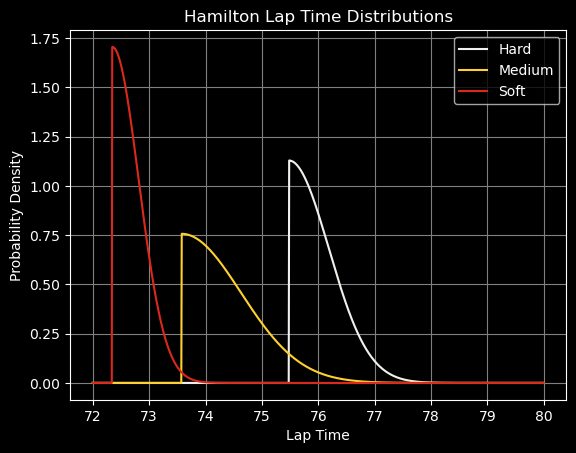

In [14]:
# define distributions for each compound
hamilton_hard_dist = sts.halfnorm(hamilton_hard_mean, hamilton_hard_std)
hamilton_medium_dist = sts.halfnorm(hamilton_medium_mean, hamilton_medium_std)
hamilton_soft_dist = sts.halfnorm(hamilton_soft_mean, hamilton_soft_std)

# plot the distributions
# set the background to be black
plt.style.use('dark_background')
# set grid lines to be grey
plt.rcParams['grid.color'] = 'grey'
# show grid lines
plt.grid(True)
x = np.linspace(72, 80, 1000)
plt.plot(x, hamilton_hard_dist.pdf(x), color = fastf1.plotting.COMPOUND_COLORS['HARD'], label='Hard')
plt.plot(x, hamilton_medium_dist.pdf(x), color = fastf1.plotting.COMPOUND_COLORS['MEDIUM'], label='Medium')
plt.plot(x, hamilton_soft_dist.pdf(x), color = fastf1.plotting.COMPOUND_COLORS['SOFT'], label='Soft')
plt.legend()
plt.xlabel('Lap Time')
plt.ylabel('Probability Density')
plt.title('Hamilton Lap Time Distributions')
plt.show()